# Computer Vision and Convolutional Neural Networks

In 2012, Alex Krizhevsky et al. competed in the [ImageNet Large Scale Visual Recognition Challenge](https://arxiv.org/abs/1409.0575). Their solution, based on a deep _Convolutional Neural Network_ (CNN) beat the runner up by more than 10% ([their paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)). Prior to this result, many thought that it was infeasable to train such deep models due to the large number parameters that need to be optimized and the associated high computational cost. Krizhevsky et al. were among the first to user GPUs to speed things up. This landmark result kicked off a wave of innovation that continues to this day. 

Convolutional Neural Networks are named thus because of the _convolution_ operation which plays a primary role in their design. You can take a look at [these slides](https://docs.google.com/presentation/d/17Uygrr1g6qBMpXOwcfZf584PkW2LTZoXgX1mqsK6syE/edit?usp=sharing) to get a sense for what the convolution operator does. Convolution is a great example of building _inductive biases_ into the network architecture. In this case, the inductive priors are _locality_ and _translation invariance_. These assumptions lead to weight sharing which significantly improves the parameter efficiency of our model relative to the fully connected neural networks that we've seen so far. 

In this notebook, we apply CNNs to the classification of handwritten characters (letters and numbers) using the [EMNIST dataset](https://www.westernsydney.edu.au/icns/reproducible_research/publication_support_materials/emnist).  The EMNIST dataset has the digits 0 through 9 and a total of 37 upper and lower-case latin characters (see Figure) for a total of 47 classes. The latin characters make EMNIST a more difficult classification task than the more famous MNIST dataset which only contains digits. We will work through a variety of architecture design considerations, will train the model for each case, and learn to reason about how architecture choices impact the performance characteristics of the model.

![Balanced EMNIST Dataset](https://www.researchgate.net/publication/329391937/figure/fig3/AS:700515201605633@1544027247072/Visualization-of-EMNIST-balanced-dataset-10-Fig2.ppm)

# Setup

In [1]:
# Library imports
import os
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from PIL import Image
import math
%matplotlib inline

# set random seed for reproducibility
_ = torch.manual_seed(0)

In [2]:
# save locations
# best not to use your home directory for reading/writing large temporary files
# /scratch is much faster!
data_dir = f"/scratch/{os.environ['USER']}/data"
model_path = f"/scratch/{os.environ['USER']}/model.pt"

# Model and Training
batch_size=64 #input batch size for training (default: 64)
test_batch_size=1000 #input batch size for testing (default: 1000)
num_workers=9 # parallel data loading to speed things up
lr=1.0 #learning rate (default: 1.0)
gamma=0.7 #Learning rate step gamma (default: 0.7)
no_cuda=False #disables CUDA training (default: False)
seed=42 #random seed (default: 42)
log_interval=10 #how many batches to wait before logging training status (default: 10)
save_model=False #save the trained model (default: False)

# additional derived settings
use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

print("Device:", device)

Device: cuda


In [3]:
# Loading the data

# Pytorch provides a number of pre-defined dataset classes
# EMNIST is one of them! Pytorch will automatically download the data.
# It will only download if the data is not already present.
data_train = datasets.EMNIST(data_dir, split='balanced', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

data_test = datasets.EMNIST(data_dir, split='balanced', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

# define pytorch dataloaders for training and testing
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=test_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# save a test batch for later testing
image_gen = iter(test_loader)
test_img, test_trg = next(image_gen)

In [4]:
print("Training dataset:", train_loader.dataset)
print("Testing dataset:", test_loader.dataset)

Training dataset: Dataset EMNIST
    Number of datapoints: 112800
    Root location: /scratch/dane2/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Testing dataset: Dataset EMNIST
    Number of datapoints: 18800
    Root location: /scratch/dane2/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


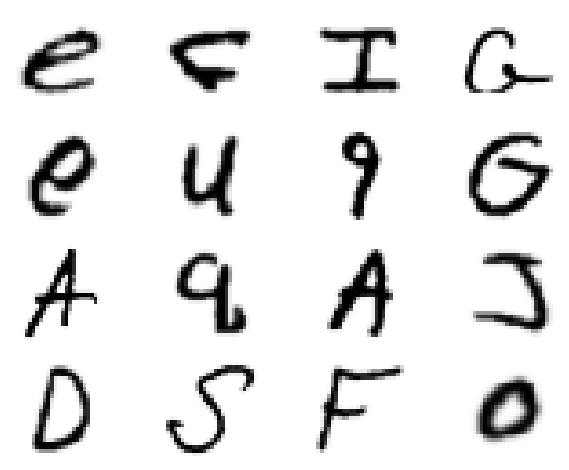

In [5]:
# Look at some examples
n_images = 16
rand_imgs = next(iter(test_loader))
ints = torch.randint(0,len(rand_imgs[0]), (n_images,))

fig, ax_arr = plt.subplots(4, 4)
ax_arr = ax_arr.flatten()

for n, ix in enumerate(ints):
    img = rand_imgs[0][ix]
    ax_arr[n].imshow(img[0].detach().cpu().numpy().T, cmap='Greys')
    ax_arr[n].axis('off')
plt.tight_layout()
plt.show()



---

**Question**: In addition to the larger number of classes in EMNIST compared to MNIST, why might it be more difficult to accurately classify images from the EMNIST set?

---


In [6]:
#@title Training and testing functions
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('\r\tTrain epoch {}: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()), end='')
            
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\rTest epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
def train_and_test(model, save_name=model_path, epochs=5):
    # @title Train the linear model
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader, epoch)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), save_name)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

# Classification architectures
We will explore a range of classification architectures starting with a linear classifier and scaling up to a several-layer convolutional neural network. Each architecture can be described in two steps (see figure below):
1. Feature extraction -- converting the raw pixel information into a _feature vector_
2. Classification -- converting the feature vector into predictions about the character in the input image.

![CNN diagram](https://miro.medium.com/max/1400/1*XbuW8WuRrAY5pC4t-9DZAQ.jpeg)

Most of the secret sauce of CNNs takes place in the feature extraction step. We will define a generic classification architecture that takes as input the sequence of operations used for feature extraction. We will use progressively more complex feature extraction pipelines. For the classification step, we will always use a single linear layer, but the number of inputs will depend on the size of the feature vector produced by the feature extractor. 

The class defined below implements this generic classifier class in pytorch. 

In [7]:
# Define the generic EMNIST classification architecture
# The `feature_extractor` argument takes images as input and produces feature vectors.
# These vectors can be of any length. 
class Classifier(nn.Module):
    def __init__(self, feature_extractor):
        super(Classifier, self).__init__()

        # feature encoder
        self.feature_extractor = feature_extractor
        
        # classifier
        self.classifier = nn.LazyLinear(47)

    def forward(self, x):
        x = self.feature_extractor(x) # Flatten -> x_i
        x = self.classifier(x) # Matrix multiply -> c_m^0 + sum(W_mi*x_i)
        x = F.softmax(x, dim=1) # apply the softmax function
        return x

# Linear Classifier

A linear classifier uses the original pixels as the features for classification. We simply need to unravel the 2D image into a vector. This is accomplished using `nn.Flatten()`. 

Note: you can safely ignore the message `UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development`

In [8]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the feature extractor
# for linear model, we just flatten the original image into a vector
feature_extractor = nn.Flatten()

# Create the model
model = Classifier(feature_extractor).to(device)

/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/envs/pytorch_workshop/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [9]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=784, out_features=47, bias=True)
)

Number of parameters in linear model: 36895


## Train and test the linear model

In [10]:
train_and_test(model)

# by default, `train_and_test` trains for 5 epochs
# you can adjust this using the epochs argument, like
# train_and_test(model, epochs=2)

Test epoch 1: Average loss: 3.3020, Accuracy: 11264/18800 (59.91%)
Test epoch 2: Average loss: 3.2766, Accuracy: 11716/18800 (62.32%)
Test epoch 3: Average loss: 3.2662, Accuracy: 11899/18800 (63.29%)
Test epoch 4: Average loss: 3.2604, Accuracy: 11989/18800 (63.77%)
Test epoch 5: Average loss: 3.2485, Accuracy: 12224/18800 (65.02%)


---

**Question**: Think of a naive performance baseline for this task. How well does it compare with that performance? Do you find this suprising given that this is just a linear model?  

---

# CNN Classifier

### One convolution layer
We now make a more interesting feature extractor using convolution. The feature extractor has the following steps: 
1. _convolution_ (`nn.Conv2d`) over the input image.
2. _batch normalization_ (`nn.BatchNorm2d`) rescales the feature maps. This helps the network converge more quickly. You can see the definition [here](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).
3. _max pooling_ (`nn.MaxPool2d`) takes the maximum pixel from each 2x2 block resulting in an image that has half the size in each dimension. 
4. _ReLU_ (`nn.ReLU`) zeroes out negative values in the feature maps. See figure:

![ReLU](https://www.researchgate.net/profile/Hossam-H-Sultan/publication/333411007/figure/fig7/AS:766785846525952@1559827400204/ReLU-activation-function.png)

In [11]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the feature extractor
feature_extractor = nn.Sequential(
    # convolution block:
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)
# Create the model
model = Classifier(feature_extractor).to(device)

In [12]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=676, out_features=47, bias=True)
)

Number of parameters in linear model: 31863


(Less than 36,895 for linear model)

---

**Question**: Why does the CNN have fewer parameters than the linear model?

---

In [13]:
train_and_test(model)

Test epoch 1: Average loss: 3.2306, Accuracy: 12472/18800 (66.34%)
Test epoch 2: Average loss: 3.1815, Accuracy: 13374/18800 (71.14%)
Test epoch 3: Average loss: 3.1571, Accuracy: 13818/18800 (73.50%)
Test epoch 4: Average loss: 3.1463, Accuracy: 14030/18800 (74.63%)
Test epoch 5: Average loss: 3.1416, Accuracy: 14139/18800 (75.21%)


---

**Question**: Why does the CNN beat the linear model after 5 epochs despite having fewer parameters?

---

**Feature maps:** let's look at the internal representations of the images produced by the 4 convolution kernel. In the picture below, the colored grids on the left are representations of the convolution kernel matrices. The values of these kernel matrices were "learned" during the training of the network. The image on the right is the feature map produced by convolving the kernel matrix with the original image. Bright areas correspond to high numerical values; dark areas correspond to low numerical values. Rerun the cell to see the feature maps for different images.


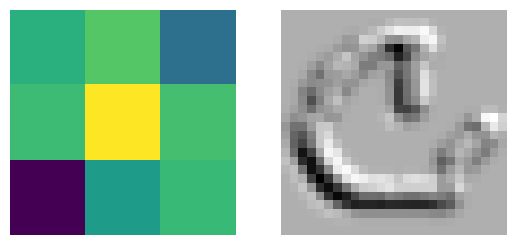

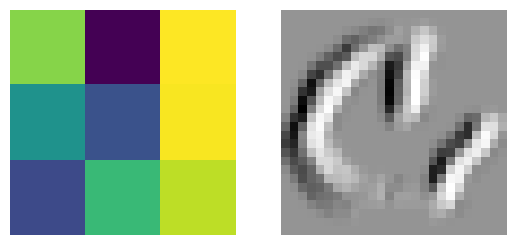

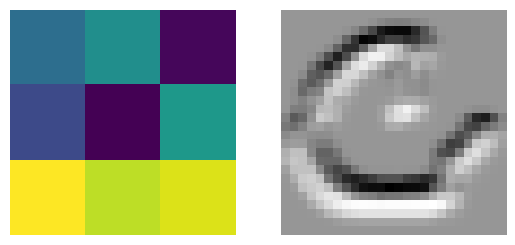

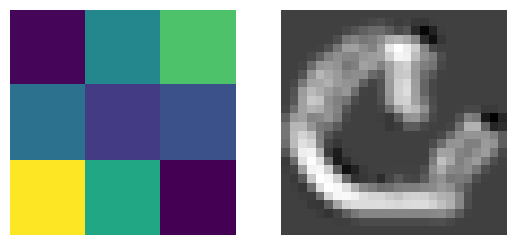

In [14]:
imgs, labels = next(image_gen)
test_img_plot = imgs[6,0]

kern = model.feature_extractor[0]

# Generate feature maps
fmaps_1 = kern(test_img_plot[None, None].cuda()).detach().cpu().numpy()[0]
for K, fmap in zip(kern.weight, fmaps_1):
    # plot kernel
    plt.subplot(1,2,1)
    mat = K.clone().detach().cpu().numpy()[0]
    plt.imshow(mat.T)
    plt.axis('off')

    # plot feature map
    plt.subplot(1,2,2)
    plt.imshow(fmap.T, cmap='Greys')
    plt.axis('off')
    plt.show()

# A "wider" model
The "width" of a CNN refers to how many feature maps are used in the convolution layers. Wide layers have many convolution kernels leading to many feature maps. In the model above, we had 4 convolution kernels (see `out_channels=4` in the `nn.Conv2d` layer in the feature extractor). Interpreting these kernels as feature extractors, it's plausible that we could improve the performance of the model by increasing the number of kernels.

The network below is the same as the previous one except that it uses twice as many kernels. 

In [15]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the feature extractor
feature_extractor = nn.Sequential(
    # convolution block:
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)

# Create the model
model = Classifier(feature_extractor).to(device)

In [16]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=1352, out_features=47, bias=True)
)

Number of parameters in linear model: 63679


Notice that doubling the number of channels nearly doubled the number of free parameters in the model. 

In [17]:
train_and_test(model)

Test epoch 1: Average loss: 3.1996, Accuracy: 13052/18800 (69.43%)
Test epoch 2: Average loss: 3.1259, Accuracy: 14404/18800 (76.62%)
Test epoch 3: Average loss: 3.1123, Accuracy: 14640/18800 (77.87%)
Test epoch 4: Average loss: 3.1058, Accuracy: 14791/18800 (78.68%)
Test epoch 5: Average loss: 3.0975, Accuracy: 14926/18800 (79.39%)


---

**Question**: How does the performance with 8 kernels compare to the performance with 4 kernels? Why do you think this might be the case?

---

# A "deeper" model


The "depth" of a CNN refers to how many convolution layers are used in the network. The feature maps from one convolution step are used as the input for the next convolution. The previous network had a single convolution step. We will now try adding more convolution layers and see how it effects performance. To isolate the effect of having more layers, we will hold the width at 4 kernels like our first CNN.

---

**Question**: Why might it be helpful to add more convolutional layers to the CNN? Can you contrast the effect of adding more depth to the effect of greater width?

---

In [18]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the encoder
# we repeat the convolution block several times
feature_extractor = nn.Sequential(
    # block 1
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # 2
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # 3
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)

# Create the model
model = Classifier(feature_extractor).to(device)

In [19]:
# @title Display model and number of parameters 
# Run one batch through the model to initialize the lazy linear layer
# this is necessary to get accurate parameter counts
with torch.no_grad():
    model(test_img.to(device)) 

display(model)

print("Number of parameters in linear model:", get_n_params(model))

Classifier(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Linear(in_features=484, out_features=47, bias=True)
)

Number of parameters in linear model: 23143


---

**Question**: The number of parameters is actually _less_ than our single layer model. We added lots of convolution kernels, so how can that be?

---

In [20]:
train_and_test(model)

Test epoch 1: Average loss: 3.1575, Accuracy: 13818/18800 (73.50%)
Test epoch 2: Average loss: 3.1159, Accuracy: 14559/18800 (77.44%)
Test epoch 3: Average loss: 3.1057, Accuracy: 14752/18800 (78.47%)
Test epoch 4: Average loss: 3.1000, Accuracy: 14839/18800 (78.93%)
Test epoch 5: Average loss: 3.0965, Accuracy: 14907/18800 (79.29%)


---

**Question**: You should find that the deeper model performed similarly to the wider model despite having many fewer parameters. Why do you think increasing the depth of the model was more parameter efficient than increasing the width?

---

---

**Question**: Which model do you think is faster 

---

# Your turn! 
Modify the feature extractor below and see how good of a score you can obtain on EMNIST. Some ideas: 
* Change the number of channels in the convolution layers. Note: the `in_channels` argument to `nn.Conv2d` must match the `out_channels` argument from a previous layer. The input image has 1 channel since the images are grayscale.
* Change the `kernel_size`, which is the size of the kernel matrix used in convolution. 
* Change the number of convolution blocks in the network.
* Try [different activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* Add or remove max pooling layers between convolution blocks
* Use a greater number of epochs in the `train_and_test` function
* Advanced: can you figure out how to add "residual"/"skip" connections? See [this paper](https://arxiv.org/abs/1512.03385). 

There are many, many possible combinations that you could try, and you can't explore them all. Try to think of a few experiments to try and record what you learn. If you want to go down the rabbit hole of trying many things, feel free, but that's not expected for this assignment.

Try to beat my score of ~80% resulting from using the "deeper model" above trained for 13 epochs.

In [21]:
# set random seed for reproducibility
torch.manual_seed(0)

# define the encoder
# we repeat the convolution block several times
feature_extractor = nn.Sequential(
    # block 1
    nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # 2
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    # 3
    nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, bias=False),
    nn.LazyBatchNorm2d(),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # flatten just as with the linear classifier
    nn.Flatten()
)

# Create the model
model = Classifier(feature_extractor).to(device)

In [22]:
train_and_test(model, epochs=13)

Test epoch 1: Average loss: 3.1626, Accuracy: 13713/18800 (72.94%)
Test epoch 2: Average loss: 3.1241, Accuracy: 14390/18800 (76.54%)
Test epoch 3: Average loss: 3.1077, Accuracy: 14720/18800 (78.30%)
Test epoch 4: Average loss: 3.0990, Accuracy: 14894/18800 (79.22%)
Test epoch 5: Average loss: 3.0946, Accuracy: 14957/18800 (79.56%)
Test epoch 6: Average loss: 3.0925, Accuracy: 14995/18800 (79.76%)
Test epoch 7: Average loss: 3.0901, Accuracy: 15035/18800 (79.97%)
Test epoch 8: Average loss: 3.0897, Accuracy: 15039/18800 (79.99%)
Test epoch 9: Average loss: 3.0889, Accuracy: 15070/18800 (80.16%)
Test epoch 10: Average loss: 3.0887, Accuracy: 15055/18800 (80.08%)
Test epoch 11: Average loss: 3.0878, Accuracy: 15083/18800 (80.23%)
Test epoch 12: Average loss: 3.0880, Accuracy: 15094/18800 (80.29%)
Test epoch 13: Average loss: 3.0880, Accuracy: 15092/18800 (80.28%)
